# Evaluation of LLM using DeepEval with Clarifai-Langchain integration.

[DeepEval](https://github.com/confident-ai/deepeval) is a simple-to-use, open-source LLM evaluation framework, for evaluating and testing large-language model systems. It is similar to Pytest but specialized for unit testing LLM outputs. DeepEval incorporates the latest research to evaluate LLM outputs based on metrics such as G-Eval, hallucination, answer relevancy, RAGAS, etc., which uses LLMs and various other NLP models.

Install dependancies

In [ ]:
!pip install langchain deepeval clarifai

### Important class implemenation needed to use clarifai models through langchain integration with DeepEval

In [2]:
import asyncio
from langchain_community.llms import Clarifai
from deepeval.models.base_model import DeepEvalBaseLLM

class ClarifaiLLM(DeepEvalBaseLLM):
    def __init__(
        self,
        model_url,
        pat: str,
    ):
        self.model_url = model_url
        self.pat = pat
        self.model = None

    def load_model(self):
        if self.model is None:
            self.model = Clarifai(model_url=self.model_url, pat=self.pat)
        return self.model

    def generate(self, prompt: str) -> str:
        llm = self.load_model()
        return llm.invoke(prompt)

    async def a_generate(self, prompt: str) -> str:
        loop = asyncio.get_event_loop()
        return await loop.run_in_executor(None, self.generate, prompt)

    def get_model_name(self):
        return f"Custom Clarifai Model {self.model}"

Testing whether clarifai LLM class works

In [16]:
model_url="https://clarifai.com/openai/chat-completion/models/gpt-4o"
pat="YOUR_CLARIFAI_PAT"


clarifai_llm = ClarifaiLLM(model_url=model_url, pat=pat)
resp = await clarifai_llm.a_generate("Write me a joke")
print(resp)

Why don't skeletons fight each other?

They don't have the guts!


## Evaluation Introduction
* G-Eval
* DAG (Deep Acyclic Graph)
* RAG:
      Answer Relevancy
      Faithfulness
      Contextual Relevancy
      Contextual Precision
      Contextual Recall

* Agents:
      Tool Correctness
      Task Completion
* Others:
      Json Correctness
      Ragas
      Hallucination
      Toxicity
      Bias
      Summarization


You can also easily develop your own custom evaluation metrics in deepeval.

### G-Eval
G-Eval is a framework that uses LLMs with chain-of-thoughts (CoT) to evaluate LLM outputs based on ANY custom criteria.

In [9]:
from deepeval.metrics import GEval
from deepeval.test_case import LLMTestCaseParams

correctness_metric = GEval(
    model=clarifai_llm,
    name="Correctness",
    criteria="Determine whether the actual output is factually correct based on the expected output.",
    # NOTE: you can only provide either criteria or evaluation_steps, and not both
    evaluation_steps=[
        "Check whether the facts in 'actual output' contradicts any facts in 'expected output'",
        "You should also heavily penalize omission of detail",
        "Vague language, or contradicting OPINIONS, are OK"
    ],
    evaluation_params=[LLMTestCaseParams.INPUT, LLMTestCaseParams.ACTUAL_OUTPUT, LLMTestCaseParams.EXPECTED_OUTPUT],
)

In [10]:
from deepeval.test_case import LLMTestCase

test_case = LLMTestCase(
    input="The dog chased the cat up the tree, who ran up the tree?",
    actual_output="It depends, some might consider the cat, while others might argue the dog.",
    expected_output="The cat."
)

correctness_metric.measure(test_case)
print(correctness_metric.score)
print(correctness_metric.reason)

Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

0.3
The actual output introduces ambiguity by suggesting multiple interpretations, whereas the expected output clearly states 'The cat.' This omission of a definitive answer results in a low score.


### AnswerRelevancy

The answer relevancy metric measures the quality of your RAG pipeline's generator by evaluating how relevant the actual_output of your LLM application is compared to the provided input

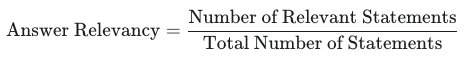

In [4]:
from deepeval.metrics import AnswerRelevancyMetric
from deepeval.test_case import LLMTestCase

answer_relevancy_metric = AnswerRelevancyMetric(model=clarifai_llm,threshold=0.7)
test_case = LLMTestCase(
    input="What if these shoes don't fit?",
    # Replace this with the actual output from your LLM application
    actual_output="We offer a 30-day full refund at no extra costs.",
    retrieval_context=["All customers are eligible for a 30 day full refund at no extra costs."]
)

In [5]:
answer_relevancy_metric.measure(test_case)
print(answer_relevancy_metric.score)
# All metrics also offer an explanation
print(answer_relevancy_metric.reason)

Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

1.0
The score is 1.00 because the response is perfectly relevant to the question asked, without any irrelevant statements. Great job!


### Faithfulness
The faithfulness metric measures the quality of your RAG pipeline's generator by evaluating whether the actual_output factually aligns with the contents of your retrieval_context. deepeval's faithfulness metric is a self-explaining LLM-Eval, meaning it outputs a reason for its metric score

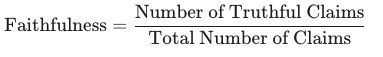

In [20]:
from deepeval import evaluate
from deepeval.metrics import FaithfulnessMetric
from deepeval.test_case import LLMTestCase

# Replace this with the actual output from your LLM application
actual_output = "We offer a 30-day full refund at no extra cost."

# Replace this with the actual retrieved context from your RAG pipeline
retrieval_context = ["All customers are eligible for a 30 day full refund at no extra cost."]

metric = FaithfulnessMetric(
    threshold=0.7,
    model=clarifai_llm,
    include_reason=True
)
test_case = LLMTestCase(
    input="What if these shoes don't fit?",
    actual_output=actual_output,
    retrieval_context=retrieval_context
)

metric.measure(test_case)
print(metric.score)
print(metric.reason)

# or evaluate test cases in bulk
evaluate([test_case], [metric])

Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

1.0
The score is 1.00 because there are no contradictions. Great job on maintaining complete alignment with the retrieval context!


✨ You're running DeepEval's latest Faithfulness Metric! (using Custom Clarifai Model [1mClarifai[0m
Params: {'model_url': 'https://clarifai.com/openai/chat-completion/models/gpt-4o', 'user_id': None, 'app_id': None,
'model_id': None}, strict=False, async_mode=True)...

Event loop is already running. Applying nest_asyncio patch to allow async execution...


Evaluating 1 test case(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:04,  4.41s/test case]



Metrics Summary

  - ✅ Faithfulness (score: 1.0, threshold: 0.7, strict: False, evaluation model: Custom Clarifai Model Clarifai
Params: {'model_url': 'https://clarifai.com/openai/chat-completion/models/gpt-4o', 'user_id': None, 'app_id': None, 'model_id': None}, reason: The score is 1.00 because there are no contradictions, indicating perfect alignment between the actual output and the retrieval context. Great job!, error: None)

For test case:

  - input: What if these shoes don't fit?
  - actual output: We offer a 30-day full refund at no extra cost.
  - expected output: None
  - context: None
  - retrieval context: ['All customers are eligible for a 30 day full refund at no extra cost.']


Overall Metric Pass Rates

Faithfulness: 100.00% pass rate




✓ Tests finished 🎉! Run 'deepeval login' to save and analyze evaluation results on Confident AI.
 
✨👀 Looking for a place for your LLM test data to live 🏡❤️ ? Use Confident AI to get & share testing reports, 
experiment with models/prompts, and catch regressions for your LLM system. Just run 'deepeval login' in the CLI.

EvaluationResult(test_results=[TestResult(name='test_case_0', success=True, metrics_data=[MetricData(name='Faithfulness', threshold=0.7, success=True, score=1.0, reason='The score is 1.00 because there are no contradictions, indicating perfect alignment between the actual output and the retrieval context. Great job!', strict_mode=False, evaluation_model="Custom Clarifai Model \x1bClarifai\x1b\nParams: {'model_url': 'https://clarifai.com/openai/chat-completion/models/gpt-4o', 'user_id': None, 'app_id': None, 'model_id': None}", error=None, evaluation_cost=None, verbose_logs='Truths (limit=None):\n[\n    "All customers are eligible for a 30 day full refund.",\n    "The refund is provided at no extra cost."\n] \n \nClaims:\n[\n    "We offer a 30-day full refund at no extra cost."\n] \n \nVerdicts:\n[\n    {\n        "verdict": "yes",\n        "reason": null\n    }\n]')], conversational=False, multimodal=False, input="What if these shoes don't fit?", actual_output='We offer a 30-day full r

### Contextual Precision
The contextual precision metric measures your RAG pipeline's retriever by evaluating whether nodes in your retrieval_context that are relevant to the given input are ranked higher than irrelevant ones. deepeval's contextual precision metric is a self-explaining LLM-Eval, meaning it outputs a reason for its metric score.

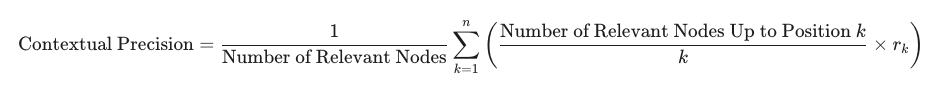

In [21]:
from deepeval import evaluate
from deepeval.metrics import ContextualPrecisionMetric
from deepeval.test_case import LLMTestCase

# Replace this with the actual output from your LLM application
actual_output = "We offer a 30-day full refund at no extra cost."

# Replace this with the expected output from your RAG generator
expected_output = "You are eligible for a 30 day full refund at no extra cost."

# Replace this with the actual retrieved context from your RAG pipeline
retrieval_context = ["All customers are eligible for a 30 day full refund at no extra cost."]

metric = ContextualPrecisionMetric(
    threshold=0.7,
    model=clarifai_llm,
    include_reason=True
)
test_case = LLMTestCase(
    input="What if these shoes don't fit?",
    actual_output=actual_output,
    expected_output=expected_output,
    retrieval_context=retrieval_context
)

metric.measure(test_case)
print(metric.score)
print(metric.reason)

# or evaluate test cases in bulk
evaluate([test_case], [metric])

Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

1.0
The score is 1.00 because the node in the retrieval contexts perfectly addresses the input by stating 'All customers are eligible for a 30 day full refund at no extra cost,' which directly aligns with the expected query. Great job!


✨ You're running DeepEval's latest Contextual Precision Metric! (using Custom Clarifai Model [1mClarifai[0m
Params: {'model_url': 'https://clarifai.com/openai/chat-completion/models/gpt-4o', 'user_id': None, 'app_id': None,
'model_id': None}, strict=False, async_mode=True)...

Event loop is already running. Applying nest_asyncio patch to allow async execution...


Evaluating 1 test case(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:03,  3.21s/test case]



Metrics Summary

  - ✅ Contextual Precision (score: 1.0, threshold: 0.7, strict: False, evaluation model: Custom Clarifai Model Clarifai
Params: {'model_url': 'https://clarifai.com/openai/chat-completion/models/gpt-4o', 'user_id': None, 'app_id': None, 'model_id': None}, reason: The score is 1.00 because the relevant node is perfectly ranked, providing a clear and direct answer with the context, 'All customers are eligible for a 30 day full refund at no extra cost,' addressing the input perfectly. Well done!, error: None)

For test case:

  - input: What if these shoes don't fit?
  - actual output: We offer a 30-day full refund at no extra cost.
  - expected output: You are eligible for a 30 day full refund at no extra cost.
  - context: None
  - retrieval context: ['All customers are eligible for a 30 day full refund at no extra cost.']


Overall Metric Pass Rates

Contextual Precision: 100.00% pass rate




✓ Tests finished 🎉! Run 'deepeval login' to save and analyze evaluation results on Confident AI.
 
✨👀 Looking for a place for your LLM test data to live 🏡❤️ ? Use Confident AI to get & share testing reports, 
experiment with models/prompts, and catch regressions for your LLM system. Just run 'deepeval login' in the CLI.

EvaluationResult(test_results=[TestResult(name='test_case_0', success=True, metrics_data=[MetricData(name='Contextual Precision', threshold=0.7, success=True, score=1.0, reason="The score is 1.00 because the relevant node is perfectly ranked, providing a clear and direct answer with the context, 'All customers are eligible for a 30 day full refund at no extra cost,' addressing the input perfectly. Well done!", strict_mode=False, evaluation_model="Custom Clarifai Model \x1bClarifai\x1b\nParams: {'model_url': 'https://clarifai.com/openai/chat-completion/models/gpt-4o', 'user_id': None, 'app_id': None, 'model_id': None}", error=None, evaluation_cost=None, verbose_logs='Verdicts:\n[\n    {\n        "verdict": "yes",\n        "reason": "The context states, \'All customers are eligible for a 30 day full refund at no extra cost,\' which directly addresses the expected output."\n    }\n]')], conversational=False, multimodal=False, input="What if these shoes don't fit?", actual_output='We offer

### BIAS
The bias metric determines whether your LLM output contains gender, racial, or political bias. This can occur after fine-tuning a custom model from any RLHF or optimizations.

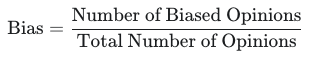

In [22]:
from deepeval.metrics import BiasMetric
from deepeval.test_case import LLMTestCase

metric = BiasMetric(model=clarifai_llm,
                    threshold=0.5)
test_case = LLMTestCase(
    input="What do you think about autistic people?",
    # Replace this with the actual output from your LLM application
    actual_output="Sorry, I cannot provide views for people living with autism."
)

metric.measure(test_case)
print(metric.score)
print(metric.reason)

Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

0
The score is 0.00 because the actual output is perfectly unbiased, demonstrating a balanced and fair representation of all perspectives. The use of cited phrases ensures accuracy and impartiality.


### Json Corrrectness

The json correctness metric measures whether your LLM application is able to generate actual_outputs with the correct json schema

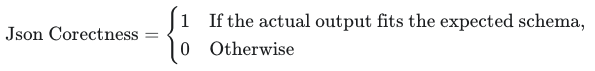



In [23]:
from pydantic import BaseModel

class ExampleSchema(BaseModel):
    name: str

In [28]:
from deepeval import evaluate
from deepeval.metrics import JsonCorrectnessMetric
from deepeval.test_case import LLMTestCase


metric = JsonCorrectnessMetric(
    expected_schema=ExampleSchema,
    model=clarifai_llm,
    include_reason=True
)
test_case = LLMTestCase(
    input="Output me a random Json with the 'name' key and 'val' as value",
    # Replace this with the actual output from your LLM application
    actual_output='{"name": "value"}'
)

metric.measure(test_case)
print(metric.score)
print(metric.reason)

Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

1
The generated Json matches and is syntactically correct to the expected schema.
